### How to make training runs faster? 

- The first thing to do is to find out the limits of your current machine 
- How much processing power do I have and how much am I currently using 
- Most torch elemnts are stored in float 32 form, but it can be useful to just use float 16 in ML beacuse we are not too focused on exact numbers
- However, refrain from using float 8 as it is mostly used for inference 
- On Andrej GPUs, using float8 gives you a 32x better performance 
- Using float16 gives you a 16x improvement over float64

- Most of the times in DL, the problem is getting data out as memory bandwidth is the most limiting resource 
- If we come down in precision, all numbers take less memory and can be accessed quicker 


##### What are tensor cores? 

- These are just matrix multiplications 
- Most computation in transformers 


#### What is TF32? 
- You just use less bits for the same operations while mantaining accuracy, 
- TF32 only uses 19bits whereas FP32 uses 32 bits of information 
- It is a free improvement in performance with GPUs 
- In principle this is 8x faster, there are still float32 numbers being shuttled around, we are still memory bound, but this is still gives a 3x output 

#### Why do you often need to use cuda.synchronize()?
- The CPU dispatches work to the GPU amd reaches time.time before the GPu is done running 
- But, this causes a problem with accurate timing, so this command makes it such that the GPu has to finish running 

##### What is the difference between FP16 and BF16? 
- Historically FP16 came out first and it essentially loses out on range and exponential value for precision and how many numbers you can display
- Before you needed gradient scalars to take care of the reduced exponents 
- BF16 allows you to sacrifice some precision for to keep full range and only take 16 bits 
- Use autocast and just surround the forward pass and loss function with this 

##### What is Pytorch.compile?
- model = torch.compile(model)
- This takes longer to start and init 
- But, this makes it much faster 
- You need to use it by default when training 
- The speed up comes from reduced python overhead, and les read/writes to GPU 
- Torch compile does not have to go layer by layer 

- A GPU has a lot more simpler cores and like a CPU it has an HBM
- We load the GPU with calculation and then shuttle back to the HBM 
- This happens for every single function and operation, so 1 + 2 + n puts 3 saves
- compile makes it so that these become a package and allows the GPU to do an operation at once, this is known as kernel fusion. 

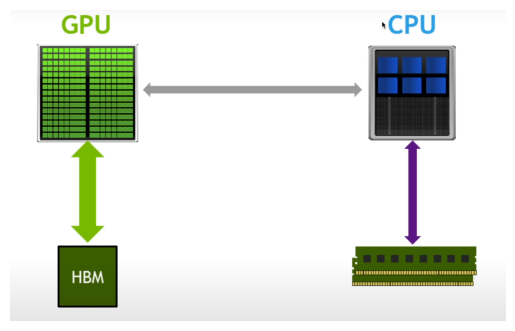

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('/workspaces/GPT2-custom/GPU fusion kernels.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

##### What is Flash Attention? 
- This is a kernel fusion program
- There are certain fusions that .compile cannot find 
- flash attention is significantly faster because it is mindful of memory allocations 
- N x N matrix is never materialized and it is a very large matrix 
- You can do an online softmax that does not require all variables to be in the function, you can do it in a "online" matter
- There are other optimizations that torch compile cannot find 
- This improves performance around 30% again 

##### Ugly Numbers and vocab size optimization 
- Lots of kernels are written in powers of 2. 
- Scan your code and look for ugly numbers 
- We get to the vocab size 50257
- A way to do this is to increase the number to the nearest number that is related to powers of 2
- Then, we get increase the vocab size to 50304
- This gives the model a 4% improvement 
- When we increase the embedding table because we never use these tokens, we see improvement 

##### Algorithmic Improvements from GPT-3
- We have to use multiple differnet hyperparameters 
- Beta = 0.9
- Epsilon = 0.95
- clip grad norm = 1, we are making sure that length of vectors is not over 1, if by accident we have a terrible batch, we can prevent shocks to the model 
- Now we also implement a cosine decay in the learning rate, 
 - The learning rate starts at 0, ramps up and decays until 10% 

##### THIS IS WHERE THE MONEY IS MADE!!!!
#### DISTRIBUTED DATA PARRALEL 
- So far we have only been using one gpu, but we have been paying for 8
- To do this we are using the DistributedDataParallel 
- This works by launching 8 processes and each process is assigned a GPU, 
- Everything is the same, all that they are doing is calculating different parts of the data 
- Then, they pretty much just change one simple calculation 
- We summon this by calling **torchrun**
-  Here are the parameters 
- DDP: Tells you if there is DDP available 
- Worldsize: 
- Rank: Which GPU you are using, this is the only thing that is different between files 
- The Local rank is a subspecialty 
- We have to set device = "cuda:{ddp_local_rank}", this tells which cuda to use 
- Master_process = is process 0 and it does logging and printing, it does some additional work 
- If we are not using DDP, then we just set everything to default 
- ddp_rnak - 0
- ddp_local_rank = 0
- world size = 1
- We don't want to always have reduntant print processes, so we can use "master_process variable"
- Here is the process with torchrun, torchrun --standalone --nproc_per_node=8 train.py
- So, we have to edit the dataloader application, we have to pass in the rank and size into the data loader
- After we create the model, we need to wrap the model in DDP()
- Forward pass, nothing changes, but in backward pass, DDP averages the gradietns and every rank is now updating the model on the average
- Now, we don't want to synchronize the gradients every single substep, we only want the synch ddp to be true if it is the final iteration 
- model.require_backward_grad_sync